### Seq 2 seq


In [ ]:
# %load train_seq2seq.py
# %load reader.py
"""Functions for downloading and reading time series data."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import random_seed

import tensorflow as tf
from tensorflow.contrib import rnn
from reader import read_data_sets
from model_seq2seq import *
from trnn import *
import numpy 
from train_config import *


flags = tf.flags
flags.DEFINE_string("model", "TLSTM",
          "Model used for learning.")
flags.DEFINE_string("save_path", "./log/tlstm/",
          "Model output directory.")
flags.DEFINE_bool("use_error_prop", True,
                  "Feed previous output as input in RNN")
flags.DEFINE_integer("hidden_size", 4, "hidden layer size")
flags.DEFINE_float("learning_rate", 1e-3, "learning rate")
flags.DEFINE_integer("rank", 2, "rank for tt decomposition")

FLAGS = flags.FLAGS

'''
To forecast time series using a recurrent neural network, we consider every 
row as a sequence of short time series. Because dataset times series has 9 dim, we will then
handle 9 sequences for every sample.
'''

# Training Parameters
config = TrainConfig()
config.use_error_prop = FLAGS.use_error_prop
config.hidden_size = FLAGS.hidden_size
config.learning_rate = FLAGS.learning_rate
config.rank_vals = [FLAGS.rank]
# Training Parameters
training_steps = 5000#config.training_steps
batch_size = config.batch_size
display_step = 200
inp_steps = config.burn_in_steps
sampling_burn_in = 400
# Read Dataset
dataset, stats = read_data_sets("./lorenz_10k.npy", True, inp_steps, inp_steps)

# Network Parameters
num_input = stats['num_input']  # dataset data input (time series dimension: 3)
out_steps = 1+stats['num_steps']- inp_steps # adding EOS


# tf Graph input
X = tf.placeholder("float", [None, inp_steps, num_input])
Y = tf.placeholder("float", [None, out_steps, num_input])

# Decoder output
Z = tf.placeholder("float", [None, out_steps, num_input])

Model = globals()[FLAGS.model]
with tf.name_scope("Train"):
    with tf.variable_scope("Model", reuse=None):
        train_pred = Model(X, Y, True, config)
with tf.name_scope("Test"):
    with tf.variable_scope("Model", reuse=True):
        test_pred = Model(X, Y, False, config)


# Define loss and optimizer
train_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(train_pred, Z)))
test_loss = tf.sqrt(tf.reduce_mean(tf.squared_difference(test_pred, Z)))
optimizer = tf.train.RMSPropOptimizer(learning_rate=config.learning_rate)
train_op = optimizer.minimize(train_loss)

# Scheduled sampling params
eps_min = 0.1 # minimal prob

# Write summary
tf.summary.scalar('loss', train_loss)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

saver = tf.train.Saver()

hist_loss =[]
# Start training
with tf.Session() as sess:
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(FLAGS.save_path + '/train',sess.graph)

    # Run the initializer
    sess.run(init)

    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_z = dataset.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, Z:batch_z})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss 
            summary, loss = sess.run([merged,train_loss], feed_dict={X: batch_x,Y: batch_y, Z:batch_z})
            run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
            run_metadata = tf.RunMetadata()
            train_writer.add_run_metadata(run_metadata, 'step%03d' % step)
            train_writer.add_summary(summary, step)
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) )
            
            # Calculate validation
            valid_enc_inps = dataset.validation.enc_inps.reshape((-1, inp_steps, num_input))
            valid_dec_inps = dataset.validation.dec_inps.reshape((-1, out_steps, num_input))
            valid_dec_outs = dataset.validation.dec_outs.reshape((-1, out_steps, num_input))
            va_loss = sess.run(test_loss, feed_dict={X: valid_enc_inps, Y: valid_dec_inps, Z: valid_dec_outs})
            print("Validation Loss:", va_loss)
            
            # Overfitting
            hist_loss.append(va_loss)
            if len(hist_loss)>20 and va_loss > np.mean(hist_loss):
                print("Early stopping: step ", step)
                break
          
            # Update sampling prob
            if step > sampling_burn_in:
                config.sample_prob = max(eps_min, 1.0-step/training_steps)
                print('Sampling prob:', config.sample_prob)

    print("Optimization Finished!")

    # Calculate accuracy for test datasets
    test_enc_inps = dataset.test.enc_inps.reshape((-1, inp_steps, num_input))
    test_dec_inps = dataset.test.dec_inps.reshape((-1, out_steps, num_input))
    test_dec_outs = dataset.test.dec_outs.reshape((-1, out_steps, num_input))

    
    # Fetch the predictions 
    fetches = {
        "true":Z,
        "pred":test_pred,
        "loss":test_loss
    }
    test_vals = sess.run(fetches, feed_dict={X: test_enc_inps, Y: test_dec_inps, Z: test_dec_outs})
    print("Testing Loss:", test_vals["loss"])

    # Save the variables to disk.
    save_path = saver.save(sess, FLAGS.save_path)
    print("Model saved in file: %s" % save_path)
    # Save predictions 
    numpy.save(save_path+"predict.npy", (test_vals["true"], test_vals["pred"]))
    # Save config file
    with open(save_path+"config.out", 'w') as f:
        f.write('hidden_size:'+ str(config.hidden_size)+'\t'+ 'learning_rate:'+ str(config.learning_rate)+ '\n')
        f.write('train_error:'+ str(loss) +'\t'+ 'test_error:'+ str(test_vals["loss"]) +'\n')

### Plot the prediction

### Plot the difference 

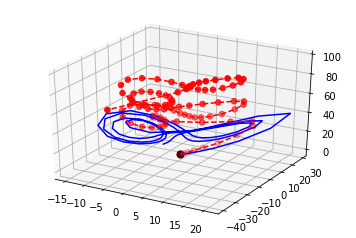

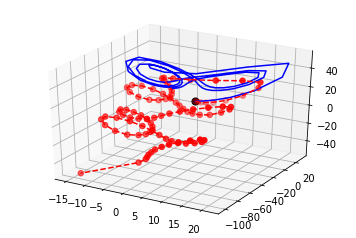

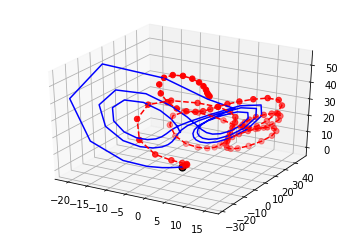

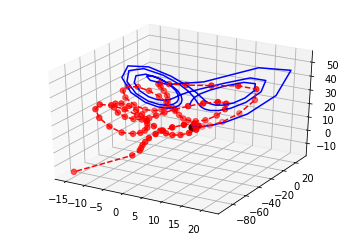

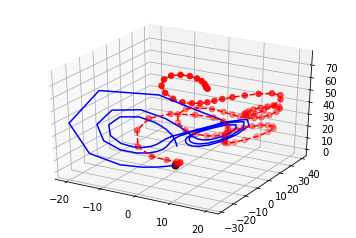

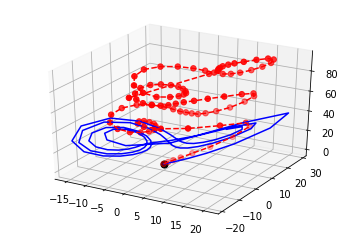

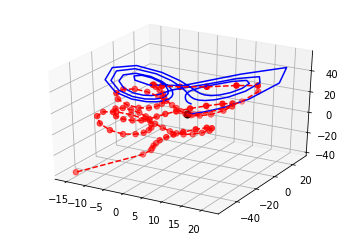

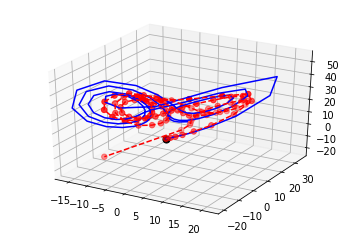

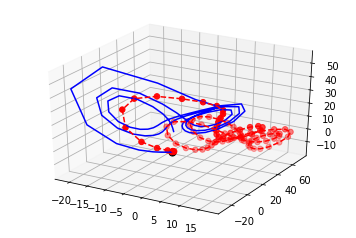

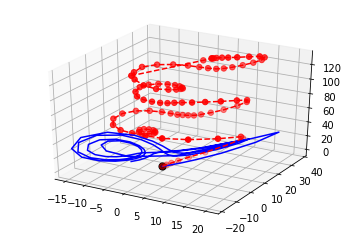